In [4]:
%matplotlib inline
import time
import glob
import re
from functools import reduce

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
import pandas as pd
import uproot_methods
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# https://arxiv.org/abs/1107.3084

In [5]:
class EventProcessor(processor.ProcessorABC):
    def __init__(self):
        d = {"counts": processor.defaultdict_accumulator(int)}
        for i in range(2,5+1):
            d["m{}j".format(i)] = processor.column_accumulator(np.zeros(shape=(0,)))
            d["pt{}j".format(i)] = processor.column_accumulator(np.zeros(shape=(0,)))
        self._accumulator = processor.dict_accumulator(d)
            
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()

        dataset = df['dataset']
        year = int(re.search("(201.)",dataset).groups()[0])

        trigger = df["HLT_PFHT900" if year==2016 else "HLT_PFHT1050"]
        jets = uproot_methods.TLorentzVectorArray.from_ptetaphim(
            df["Jet_pt"],df["Jet_eta"],df["Jet_phi"],df["Jet_mass"]
        )
        jets["isgood"] = (((df["Jet_jetId"] >> 2) > 0) 
                          & (df["Jet_cleanmask"] > 0) 
                          & (np.abs(jets.eta) < 3.0) 
                          & (jets.pt > 40.))
        jets = jets[jets["isgood"]]
        ht = jets.pt.sum()
        isgood = trigger & (jets.counts >= 6) & (ht > 1150)
        
        def nchoosek(n,k):
            nk = jets[isgood,:n].choose(k)
            mass =  reduce(lambda x,y:x+y, [nk[str(i)] for i in range(k)]).mass.flatten()
            pt =  reduce(lambda x,y:x+y, [nk[str(i)].pt for i in range(k)]).flatten()
            return mass,pt
            
        for n,k in [(5,2), (6,3), (6,4), (7,5)]:
            mass,pt = nchoosek(n,k)
            output["m{}j".format(k)] = processor.column_accumulator(mass)
            output["pt{}j".format(k)] = processor.column_accumulator(pt)
        
        output["counts"]["total"] += len(jets)

        return output

    def postprocess(self, accumulator):
        return accumulator


In [6]:
fileset = {
    "jetht_2016": glob.glob("/hadoop/cms/store/user/namin/nanoaod/JetHT__Run2016*/*.root"),
    "jetht_2017": glob.glob("/hadoop/cms/store/user/namin/nanoaod/JetHT__Run2017*/*.root"),
    "jetht_2018": glob.glob("/hadoop/cms/store/user/namin/nanoaod/JetHT__Run2018*/*.root"),
}

t0 = time.time()
output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=EventProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 24},
                                  chunksize=1500000,
                                 )
elapsed = time.time()-t0
print("{} events @ {:.1f}kHz".format(output["counts"]["total"],0.001*output["counts"]["total"]/elapsed))


204966706 events @ 423.1kHz


In [112]:
d = {}
for i in range(2,5+1):
    d[i] = dict(
        pt = output["pt{}j".format(i)].value,
        m = output["m{}j".format(i)].value,
    )

Text(0, 0.5, 'Entries')

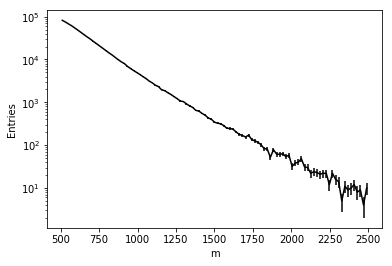

In [127]:
k = 3
fig,ax = plt.subplots()
delta = 130.
bins = np.linspace(500,2500,100)
counts,edges = np.histogram(d[k]["m"][d[k]["m"]<(d[k]["pt"]-delta)],bins=bins)
ax.errorbar(0.5*(edges[:-1]+edges[1:]),counts,yerr=np.sqrt(counts),color="k")
ax.set_yscale("log")
ax.set_xlabel("m")
ax.set_ylabel("Entries")

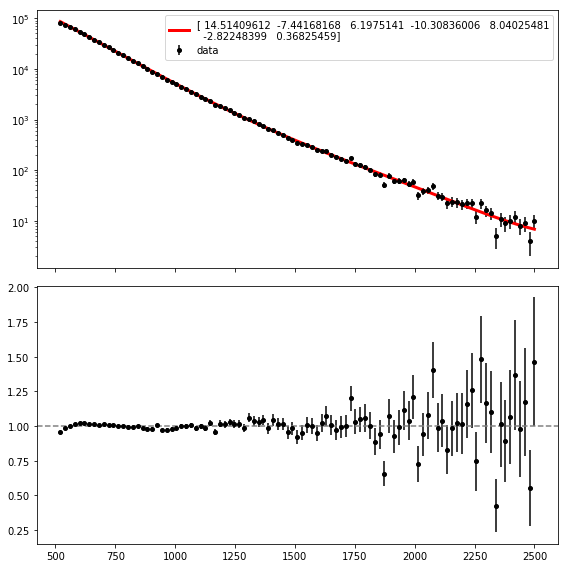

In [128]:
# counts
# xs = 0.5*(bins[1:]+bins[:-1])
xs = np.ediff1d(bins.cumsum()) # same as above

# def f(x,a,b,c,d): return a*np.exp(-0.01*b*x)-c*x**3.-d*x
def f(x,a,b,c,d,e,f,g): 
    return a+b*(x/1000)+c*(x/1000)**2+d*(x/1000)**3+e*(x/1000)**4+f*(x/1000)**5+g*(x/1000)**6
# def f(x,a,b,c): return a*x+b
ys = np.log(counts)

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,8),sharex=True)
popt,pcov = curve_fit(f,xs,ys)
ysfit = f(xs,*popt)

ys = np.exp(ys)
ysfit = np.exp(ysfit)

ax1.errorbar(xs,ys,yerr=(ys**0.5),label="data",color="k",ls="none",marker="o",ms=4.0)
ax1.plot(xs,ysfit,label=popt,color="r",lw=3)
ax1.legend()
ax1.set_yscale("log")

ratio = ys/ysfit
ratioerr = (ys**0.5)/ysfit
# ratioerr = 
ax2.errorbar(xs,ratio,yerr=ratioerr,color="k",ls="none",marker="o",ms=4.0)
ax2.axhline(1.0,color="0.5",ls="--",lw=1.5)
fig.set_tight_layout(True)

Text(0.5, 1.0, 'data')

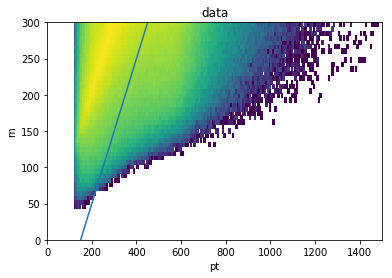

In [129]:
fig,ax = plt.subplots()
bins = [np.linspace(0,1500,200),np.linspace(0,300,50)]
ax.hist2d(d[3]["pt"],d[3]["m"],bins=bins,norm=LogNorm());
ax.plot(bins[0],bins[0]-150.)
ax.set_xlabel("pt")
ax.set_ylabel("m")
ax.set_title("data")